In [18]:
import torch
import numpy as np
import time
from tqdm import tqdm
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as io

# required for solving issue with spyder
#io.renderers.default='browser'
if torch.cuda.is_available():
    device = torch.device('cuda:0')
    print(torch.cuda.get_device_properties(device))
else:
    device = torch.device('cpu')
    print('torch utilize cpu')
    torch.set_num_threads(1)

torch utilize cpu


In [12]:
def init_row(start_point, end_point, N_parts):   
    row = torch.linspace(start=start_point , end=end_point, steps=N_parts)
    return torch.unsqueeze(row, dim=0)

def neg_check(vec):
    vec=vec[vec<0]
    if len(vec) == 0:
        return True
    else:
        return False


def init_matrix(device = 'cpu', *rows):
    return torch.cat((rows), 0).to(device)


def mov_av(x):
    # moving average with window = 2
    return (x[:-1] + x[1:])/2

def deriv1_sym(x, ds):
    # symmetric derivative (x[i+1] - x[i-1])
    return (x[2:] - x[:-2])/(2*ds)
    

class ShapeOptimizer():
    
    '''Here, the variables important for the functions below are set. 
    moduls - responsible for the choice of modules in the expression for the layer energy;
    in_param - list for initial values needed for each individual layer;
    r_start - initial point for calculation along r axis;
    z_start - initial point for calculation along z axis;
    L - The perimeter of the contour formed by section along r-z plain of the inner
    monolayer surface;
    augmentation - whether to add a penalty to the energy for non-compliance with the
    width condition;
    D - figure width (distance from the first point to the last one along the r axis),
    necessary for augmentation;
    rho - multiplier to adjust the penalty scale;
    lam - variable for linear penalty tuning.
    '''
    def __init__(self, r_start=0, L=0, D=0, z_start=0, augment=False, rho=1,
        lam=1, po=2, sym=True, moduls={'B':1, 'sigma':1, 'Kt':0, 'Ka':0},
        in_param={'Js_u':0, 'Js_l':0, 'h0u':1.6, 'h0l':1.6}):

        self.r_start = torch.tensor([r_start]).to(device)
        self.L = torch.tensor([L]).to(device)
        self.D = D
        self.B = moduls.get('B', 0) 
        self.sigma = moduls.get('sigma', 0)
        self.Kt = moduls.get('Kt', 0)
        self.Ka = moduls.get('Ka', 0)
        self.h0u = torch.tensor([in_param.get('h0u', 1.6)]).to(device)
        self.h0l = torch.tensor([in_param.get('h0l', 1.6)]).to(device)
        self.Js_u = torch.tensor([in_param.get('Js_u', 0)]).to(device)
        self.Js_l = torch.tensor([in_param.get('Js_u', 0)]).to(device)
        self.augment = augment
        self.rho = rho
        self.lam = lam
        self.po = 4
        self.z_start = torch.tensor([z_start]).to(device)
        self.delta = 0.0001
        self.sym = sym
        
    '''Function for generall procesing which used in energy and sym_syst function.
    vec - vector of angles from which other parameters will be derived.
    '''
    def gen_proc(self, vec):
        
        # First row of matrix represent angles between tangents and r-axis
        theta = vec
        sin = torch.sin(theta)
        cos = -torch.cos(theta)
            
        # First and last element ds should be halved, since it begins from 
        # tangent point of the figure
        cos[0] = cos[0]/2
        cos[-1] = cos[-1]/2  
        # Height of the figure
        L_curr = torch.sum(sin) - (sin[0]+sin[-1])/2
        # Adapt ds to the figure height
        ds = abs(self.L/L_curr)
        # List of r coordinate. Add start coordinate
        r = self.r_start + ds*torch.cumsum(cos, dim=0)
        r = torch.cat((self.r_start, r))
        
        # Taking r at the centers of ds elements
        r_av = mov_av(r)
        
        return theta, sin, ds, r, r_av


    '''Function for calculation energy. Matrix - all required for calculation data in 
    one array with 3 or 5 rows. Calc - set of calculated layers.
    In this calculaitons ds is adjusted to the length of the figure along the z axis
    '''
    def energy(self, matrix, calc={'upper'}, theta=None, sin=None, ds=None, r=None, r_av=None):

        # Used for correct numeration of rows in array
        count = 0
        point = 0
        
        # Check that some parameters calculated befaore 
        if theta == None or sin == None or ds == None or r == None:
            theta, sin, ds, r, r_av = self.gen_proc(matrix[0])
       
        # First and last elements of r_av should be same as for r
        r_av[0] = r[0] + self.delta
        r_av[-1] = r[-1] + self.delta
        
        # Symmetric derivative of theta
        dtheta = deriv1_sym(theta, ds)
        # Expansion of the vector of derivatives for operations with others in
        # our calculations
        dtheta = torch.cat((torch.unsqueeze(dtheta[0], 0), dtheta,
            torch.unsqueeze(dtheta[-1], 0)))
        
        # Curvature term whcih is common to both (only the sign changes)
        J = -dtheta + sin/r_av 
            
        if 'upper' in calc:
            # Second row of matrix represent angles between direcots and z-axis
            dir_u = matrix[1]
            # Extraction row with height of layer
            h_u = matrix[2]
            # Tilt term
            t_u = torch.sin(dir_u - np.pi/2 + theta)
            # Expansion term
            alpha_u = 1 - h_u/self.h0u - J*self.h0u**2/2
            # Calculating energy of each point
            point = self.B*(J + self.Js_u)**2 + self.Ka*alpha_u**2 + self.Kt*t_u**2 +\
                2*self.sigma             
            count = 3
        
        if 'lower' in calc:
            # Second row of matrix represent angles between direcots and z-axis
            dir_l = matrix[count]
            # Extraction row with height of layer
            h_l = matrix[count+1]
            # Tilt term
            t_l = torch.sin(dir_l - np.pi/2 + theta)
            # Expansion term
            alpha_l = 1 - h_l/self.h0l + J*self.h0l**2/2
            # Calculating energy of each point
            point += self.B*(-J + self.Js_l)**2 + self.Ka*alpha_l**2 + self.Kt*t_l**2 +\
                2*self.sigma

        # First and last elements should be halved
        point[0] = point[0]/2
        point[-1] = point[-1]/2
        en = np.pi*ds*(torch.dot(r_av, point))
        
        # Penalty condition check
        if self.augment:
            # Currend width of the figure
            D_curr = (max(r) - self.r_start)
            # Penalty for the deviation from the figure width
            penalty = self.rho*(self.D - D_curr - self.lam)**self.po
        else:
            penalty = 0

        return (en + penalty)
            
    
    # This functions is dedicated for printing profile of lipid system
    # prin_dat = {'upper', 'lower', 'upper_director', 'lower_director', 'intermonolayer'}
    def shape(self, matrix, prin_dat = {'upper','intermonolayer'}):
        
        # Intermonolayer angles extraction
        theta = matrix[0]
        sin = torch.sin(theta)
        cos = -torch.cos(theta)            
        # First and last element ds should be halved, since it begins from
        # tangent point of the figure have to make a copy of sin, since it
        # is used for curvature calculations too.
        cos[0] = cos[0]/2
        cos[-1] = cos[-1]/2
        sin[0] = sin[0]/2
        sin[-1] = sin[-1]/2
        # Height of the figure
        L_curr = torch.sum(sin)
        # Adapt ds to the figure height
        ds = abs(self.L/L_curr)        
        # List of r coordinate for upper layer. Add start coordinate
        r = self.r_start + ds*torch.cumsum(cos, dim=0)
        r = torch.cat((self.r_start, r))
        # List of r coordinate for lower layer. Add start coordinate
        z = self.z_start + ds*torch.cumsum(sin, dim=0)
        z = torch.cat((torch.tensor([self.z_start]).to(device), z))     
        # Dict with numpy array elemnts where fist row is values on r-axis and
        # second row is element
        shape = {'intermonolayer': torch.vstack((r, z)).to('cpu').detach().numpy()}
        
        if 'upper_director' in prin_dat or 'upper'in prin_dat:
            # Change reference axis for angle comparison 
            dir_u = matrix[1] + np.pi/2
            # Calculating director projections to z-axi
            dir_sin_u = torch.sin(dir_u)
            # Adding to dict data for upper director
            if 'upper_director' in prin_dat:
                shape['upper_director'] = torch.vstack((r, dir_sin_u)).to('cpu').\
                detach().numpy()
        
        if 'upper' in prin_dat:
            # The thickness of the lipid layer in the dimension of the director
            h_u = matrix[2]
            z_u = h_u*dir_sin_u
            r_u = h_u*torch.cos(dir_u)
            r_u = r - torch.cat((torch.unsqueeze(2*r_u[0]-r_u[1], 0), r_u))    
            z_u = z - torch.cat((torch.unsqueeze(2*z_u[0]-z_u[1], 0), z_u))
            shape['upper'] = torch.vstack((r_u, z_u)).to('cpu').detach().numpy()
        
        # Counter for proper arrangement of matrix elements
        if matrix.size(dim=0) == 3:
            count = 0
        else:
            count = 2
            
        if 'lower_director' in prin_dat or 'lower' in prin_dat:
            # Change reference axis for angle comparison 
            dir_l = matrix[count+1] - np.pi/2
            # Calculating director projections to z-axi
            dir_sin_l = torch.sin(dir_l)
            # Adding to dict data for lower director
            if 'lower_director' in prin_dat:
                shape['lower_director'] = torch.vstack((r, dir_sin_l)).to('cpu').\
                    detach().numpy()

        if 'lower' in prin_dat:
            # The thickness of the lipid layer in the dimension of the director
            h_l = matrix[count+2]
            z_l = h_l*dir_sin_l
            r_l = h_l*torch.cos(dir_l)
            r_l = r - torch.cat((torch.unsqueeze(2*r_l[0]-r_l[1], 0), r_l))    
            z_l = z - torch.cat((torch.unsqueeze(2*z_l[0]-z_l[1], 0), z_l))
            shape['lower'] = torch.vstack((r_l, z_l)).to('cpu').detach().numpy()
                             
        return shape


'''Function for calculation elastic energy of stalk.
matrix - input matrix consist of vectors for each parameter
distal - shapeoptimazer class object belongs to part formed by distal monolayers;
proximal - shapeoptimazer class object belongs to part formed by proximal monolayers;
D - total length of simulated system along r-axis;
dia_len - length of hemifusion diaphragm after which stalk part formed by
proximal monolayers is started;
height - height of stalk structure; 
n - numbers of columns belong to one diaphragm part;
a - coef between positive volume and additional energy;
b - coef between negative volume and additional energy;
add_en - switcher for calculation of additional energy:
0 disable volume calculation,
1 enable only physical volume,
2 enable bouth volumes unphysical penalty and physical volume 
'''
def sym_syst(matrix, distal, proximal, D, dia_len, height, n=100, a=10, b=20,
             c=30, add_en=0, ret_vol = False, vol_type = 1):

    # Obtaining of common parameters from gen_proc function.
    theta_d, sin_d, ds_d, r_d, r_dav = distal.gen_proc(matrix[0,:n])
    theta_p, sin_p, ds_p, r_p, r_pav = proximal.gen_proc(matrix[0,n:])
    # Elastic energy calculation
    out = distal.energy(matrix[:,:n], calc={'upper'}, theta=theta_d,
                        sin=sin_d, ds=ds_d, r=r_d, r_av=r_dav)
    out += proximal.energy(matrix[:,n:], calc={'lower'}, theta=theta_p,
                        sin=sin_p, ds=ds_p, r=r_p, r_av=r_pav)
    vo_out = 0
    # Addition to the energy
    if add_en in {1,2}:
        # Calculaiton heights of each point in Zr plane.
        z_d = ds_d*torch.cumsum(sin_d, dim=0)
        z_d = torch.cat((torch.tensor([0]), z_d))
        z_p = ds_p*torch.cumsum(sin_p, dim=0) 
        z_p = torch.cat((torch.tensor([0]), z_p))
        z_dav = mov_av(z_d)
        z_pav = mov_av(z_p)  
        dir_r_d = r_d[1:] - r_d[:-1]
        dir_r_p = r_p[1:] - r_p[:-1]
        
        # Dividing the parameters for the distal monolayer into two parts where the
        # first does not intersect with another monolayer. Take into acount that 
        # sliece didn't include last elemnt
        len1 = len(r_d[r_d < dia_len]) - 1
        r_f = r_dav[:len1]
        r_s = r_dav[len1:]
        dir_r_f = dir_r_d[:len1]
        dir_r_s = dir_r_d[len1:]
        z_f = z_dav[:len1]
        z_s = z_dav[len1:]
        
        # Conrvertion case with negative volume to positive with relation
        # to chosen constant a and c.
        vol0 = r_f*z_f*dir_r_f
        vol0[vol0>0] *= a
        
        if add_en == 1:
            vol0[vol0<0] = 0
        elif add_en == 2:
            vol0[vol0<0] *= -c
            
        # Addition to energy caused by volume expansion
        vo_out += np.pi*2*torch.sum(vol0)
        # 2 vectors of volumes for each point in grid
        vol1 = r_s*z_s*dir_r_s
        vol2 = r_pav*z_pav*dir_r_p
        '''
        vol1 = r_s*z_s
        vol2 = r_pav*z_pav
        '''
        
        # Calculate addition energy caused by crossing zero (meaningless case)
        if add_en == 2:
            # 2 vectors of volumes for each point in grid
            vol1_z = -vol1[vol1<0]*c
            vol2_z = -vol2[vol2<0]*c
            vo_out += np.pi*2*torch.sum(vol1_z)  
            vo_out += np.pi*2*torch.sum(vol2_z)
        
        # Discarding negative volumes due to considering above
        vol1[vol1<0] = 0
        vol2[vol2<0] = 0
        
        if vol_type == (0 or 1):
            
            if max(r_d) < max(r_p) or vol_type == 0:
                r_a = r_d[len1:]
                r_b = r_p
                vol_com = vol2
                dir_r = dir_r_p
                len2 = len(r_p)
            else:
                r_a = r_p
                r_b = r_d[len1:]
                vol_com = vol1
                dir_r = dir_r_d
                len2 = len(r_d[len1:])
                
            j = 0
            add2 = 0
            mul = 0
            vol3 = torch.empty(0, dtype=float)
    
            for  el in r_a[1:]:
                add1 = 0
                
                if j+1 < len2:
                    while r_b[j+1] <= el:          
                        add1 += vol_com[j]
                        add1 += add2
                        add2 = 0
                        j += 1
                        if j+1 >= len2: 
                            break
                        
                    if j+1 < len2:          
                        if add1 == 0:
                            mul = (r_b[j+1] - el)/dir_r[j]
                            add1 = vol_com[j]*(1 - mul) + add2
                            add2 += -add1
                        
                        elif r_b[j] != el:               
                            mul = (r_b[j+1] - el)/dir_r[j]
                            add1 += vol_com[j]*(1 - mul) +add2
                            add2 += -vol_com[j]*(1 - mul)
                            
                vol3 = torch.cat((vol3, torch.tensor([add1]) ))
    
            if vol_type == 0:
                
                if j+1 < len2:
                    add1 = add2  
                    for i in range(j, len2-1):          
                        add1 += vol2[i]
                          
                    vol3[-1] += add1
                    
                res = vol1 - vol3
                  
            elif len2 == len(r_p):
                res = vol1 - vol3
            elif len2 == len(r_d[len1:]):
                #print(vol3[-1], len(vol1), vol2[-1])
                res = vol3 - vol2
                
        elif vol_type ==  2:
            
            # We start comparing radii not from zero, since there is no volume
            # for this point
            j=1
            len2 = len(r_p)
            # List of proximal monolayers volumes belongs to each volume from
            # distal monolayer
            temp2 = torch.empty(0, dtype=float)
            
            for comp in r_d[len1+1:]:
                add = 0
                if j < len2:
                    while r_p[j] < comp:          
                        add += vol2[j-1]
                        j += 1
                        if j >= len2:
                            break
                temp2 = torch.cat(( temp2, torch.tensor([add]) )) 

            # List of volumes of distal monolayer obtained by considering zero 
            # values in temp 2 list      
            temp1 = torch.empty(0, dtype=float)
            add = 0
            # This loop required for check cases when dat1 contain zero elements
            # due to abscence of radii in r_p vector for certain interval.
            for i in range(len(temp2)):
                if temp2[i] == 0:
                    add += vol1[i]
                else:
                    add += vol1[i]
                    temp1 = torch.cat(( temp1, torch.tensor([add]) )) 
                    add = 0
            
            temp2 = temp2[temp2!=0]
            res = (temp1-temp2)*a
            
            # Loop for counting negative volumes substaction and replacing it with 
            # positive values multiplied with c constant
            count = 0
            add = 0
            for i in range(len(res)):
                if res[i] < 0:
                    count += 1
                    add += -res[i]
                else:
                    if count > 1:
                        res[i-count:i] *= -b/a
                        #print(len(res[i-count:i]))
                    # To identify cases when two adjacent points have a negative
                    # volume modulo one is much greater than the positive volume 
                    # of the other. If they differ by less than two times, this 
                    # can be explained by jumping through two points at once by
                    # the loop above.
                    elif count == 1 and add > res[i]+res[i-2]:
                        res[i-1] = -res[i-count:i]*(b/a)
                    add = 0
                    count = 0
            
        res[res>0] *= a
        res[res<0] *= -b
        vo_out += np.pi*2*torch.sum(res)    
        out += vo_out
        
    if ret_vol:
        return out, vo_out
    elif ret_vol == False:
        return out
    

# This function necessary for making matrix for stalk structure
def in_mat_rude(D, dia_len, height, point_num = 200, in_param_dis={'h0u':1.6},
                  in_param_pro={'h0l':1.6}, circ=True, de=4):
    
    # Height in calculated system 
    L=height/2
    # Coeficient between number of points and len of specified part of task
    alpha = point_num/(dia_len + 2*(D-dia_len)+L)
    n = int((D+L/3)*alpha)
    # Angle for diaphragm part
    ang1 = np.arctan(3*L/(4*dia_len))
    # Angle for opposite membranes part
    ang2 = np.arctan(L/(4*(D-dia_len)))
    # Proportion between numbers of points for parts of a monolayer
    prop = dia_len/np.cos(ang1)/(dia_len/np.cos(ang1)+(D-dia_len)/np.cos(ang2))
    # First two element belong to distal monolayers
    theta =[torch.linspace(start=np.pi-ang1, end=np.pi-ang1,
        steps=int(n*prop))]
    theta.append(torch.linspace(start=np.pi-ang2, end=np.pi-ang2,
        steps=n-int(n*prop)))
    
    if circ == True:
        if L/2 < (D-dia_len):
            ang2 = np.arctan(L*(1-np.sqrt(2)/2)/(D-dia_len-L*(1-np.sqrt(2)/2)))
            # Proportion between numbers of points for parts of a monolayer
            prop = L*np.pi/4/(L*np.pi/4+(D-dia_len-L*(1-np.sqrt(2)/2))/np.cos(ang2))
        else:
            prop = 1
        # Part of proximal monolayer with radial distribution
        theta.append( torch.linspace(start=np.pi/2 , end=np.pi*3/4,
            steps=int(prop*(point_num-n))) )
        
    elif circ == False:
        if L/2 < (D-dia_len):
            ang1 = np.arctan( L*( 3/4 + 1/(4*de) )/( (D-dia_len)/de ) )
            # Proportion between numbers of points for parts of a monolayer
            prop = 1/np.cos(ang1)/de / (1/np.cos(ang1)/de + (1-1/de)/np.cos(ang2))
        else:
            prop = 1
        # Part of proximal monolayer with radial distribution
        theta.append( torch.linspace(start=np.pi-ang1, end=np.pi-ang1,
            steps=int(prop*(point_num-n))) )
        
    if L/2 < (D-dia_len):
        # Angle for opposite membranes part
        theta.append( torch.linspace(start=np.pi-ang2, end=np.pi-ang2,
            steps=point_num-n-int(prop*(point_num-n))) )
    
    theta = torch.cat(theta)
    # Add second dimension for tensor
    theta = torch.unsqueeze(theta, dim=0)    
    # Assumption that director in normal direction in all point
    direc = np.pi - theta
    h = [ torch.linspace(start=in_param_dis['h0u'] , end=in_param_dis['h0u'],
                         steps=n) ]
    h.append( torch.linspace(start=in_param_pro['h0l'] , end=in_param_pro['h0l'],
                         steps=point_num-n) )
    h = torch.cat(h)
    h = torch.unsqueeze(h, dim=0)
    
    matrix = torch.cat((theta, direc, h), 0)
    matrix.to(device)
    matrix.requires_grad=True
    
    return matrix, n


def in_with_dia(matrix, n, a, dia_len):
    
    # Obtaining of common parameters from gen_proc function.
    theta_d, sin_d, ds_d, r_d, r_dav = distal.gen_proc(matrix[0,:n])
    # Elastic energy calculation
    out = distal.energy(matrix[:,:n], calc={'upper'}, theta=theta_d,
                        sin=sin_d, ds=ds_d, r=r_d, r_av=r_dav)
    z_d = ds_d*torch.cumsum(sin_d, dim=0)
    z_d = torch.cat((torch.tensor([0]), z_d))
    z_dav = mov_av(z_d)
    dir_r_d = r_d[1:] - r_d[:-1]
    
    # Dividing the parameters for the distal monolayer into two parts where the
    # first does not intersect with another monolayer. Take into acount that 
    # sliece didn't include last elemnt
    len1 = len(r_d[r_d < dia_len]) - 1
    r_f = r_dav[:len1]
    dir_r_f = dir_r_d[:len1]
    z_f = z_dav[:len1]
    
    # Conrvertion case with negative volume to positive with relation
    # to chosen constant a and c.
    vol0 = r_f*z_f*dir_r_f
    vol0[vol0>0] *= a
    vol0[vol0<0] *= -c
        
    # Addition to energy caused by volume expansion
    out += np.pi*2*torch.sum(vol0)
    
    return out


def in_mat_opt(D, dia_len, height, moduls_dis, in_param_dis, moduls_pro, in_param_pro,
               point_num, rho, lam, po, a, c, distal, proximal, augment=True):
    
    # Height in calculated system 
    L=height/2
    # Coeficient between number of points and len of specified part of task
    alpha = point_num/(2*D-dia_len+L)
    # number from which elements of matrix belong to another monolayer
    n = int((D+2*L/5)*alpha)
    # Angles for diaphragm part
    ang1 = np.arctan(L/D)
    ang2 = np.arctan(L/(D-dia_len))
    theta =[torch.linspace(start=np.pi-ang1, end=np.pi-ang1,
        steps=n)]
    theta.append(torch.linspace(start=np.pi-ang2, end=np.pi-ang2,
        steps=point_num-n))
    
    theta = torch.cat(theta)
    # Add second dimension for tensor
    theta = torch.unsqueeze(theta, dim=0)    
    # Assumption that director in normal direction in all point
    direc = np.pi - theta
    h = [ torch.linspace(start=in_param_dis['h0u'] , end=in_param_dis['h0u'],
                         steps=n) ]
    h.append( torch.linspace(start=in_param_pro['h0l'] , end=in_param_pro['h0l'],
                         steps=point_num-n) )
    h = torch.cat(h)
    h = torch.unsqueeze(h, dim=0)
    
    matrix = torch.cat((theta, direc, h), 0)
    matrix.to(device)
    matrix.requires_grad=True
    
    fn_his_1 = []
    var_his_1 = []
    
    for i in tqdm(range(100000)):
        var_his_1.append(matrix.clone())
        function_result = in_with_dia(matrix, n, a, c)
        fn_his_1.append(function_result.data.cpu().numpy().copy())
        function_result.backward()
        optimizer.step()
        #scheduler.step()
        
    fn_his_2 = []
    var_his_2 = []
    calc = {'lower'}
    for i in tqdm(range(100000)):
        var_his_2.append(matrix.clone())
        fn_his_2.append(model.energy(matrix, calc).data.cpu().numpy().copy())
        make_gradient_step(model.energy, matrix, calc)
        #scheduler.step()

    plt.plot(fn_history)


    plt.plot(fn_his_1)
    
    return var_his_1, n, distal, proximal

# funstion for energy function minimizaation
def make_gradient_step(function, variable, calc = {'upper'} ):
    function_result = function(variable, calc)
    optimizer.zero_grad()
    function_result.backward()
    optimizer.step()
 
    
def sys_grad_step(matrix, distal, proximal, D, dia_len,
                  height, n, a, b, c, add_en):
    function_result = sym_syst( matrix, distal, proximal, D, dia_len,
                      height, n, a, b, c, add_en)
    optimizer.zero_grad()
    function_result.backward()
    optimizer.step()

    
def time_test(function, matrix, N_steps, calc={'upper'}):

    tt = time.time()
    for i in range(N_steps):
        function(matrix)

    print(f'Time for one evaluation = {1000*(time.time() - tt)/N_steps:.3} ms')

In [13]:
N_parts = 100
R = 2
L = 1
B = 1
sigma = 1
moduls = {'B':0, 'sigma':0.05, 'Kt':10, 'Ka':25}

# Sphere formed by equidistant layers.
theta_sph = torch.linspace(start=np.pi*9/10, end=np.pi*9/10, steps=N_parts)
theta_sph = torch.unsqueeze(theta_sph, dim=0)
dir_sph = np.pi - theta_sph
h_u = torch.linspace(start=1 , end=1, steps=N_parts)
h_u = torch.unsqueeze(h_u, dim=0)
matrix = torch.cat((theta_sph, dir_sph, h_u, dir_sph, h_u), 0)  
matrix.to(device)
matrix.requires_grad=True
model = ShapeOptimizer(r_start = 0, D = 12, L = 4, z_start = 0, moduls = moduls,\
    augment = True, rho = 1, lam = 1,  in_param={'Js_u':0, 'Js_l':0})

optimizer = torch.optim.Adam([matrix], lr=0.001)
#optimizer = torch.optim.SGD([theta], lr=0.01, momentum=0.9)
#optimizer = torch.optim.LBFGS([theta], lr=0.52)
#import torch.optim.lr_scheduler as sh
#scheduler = sh.ExponentialLR(optimizer, gamma=1.001)
#scheduler = sh.MultiStepLR(optimizer, milestones=[100, 200], gamma=3)

100%|█████████████████████████████████████████████████████████████████████████| 100000/100000 [06:45<00:00, 246.64it/s]


[32.53881]
Time used = 4.06e+02 s


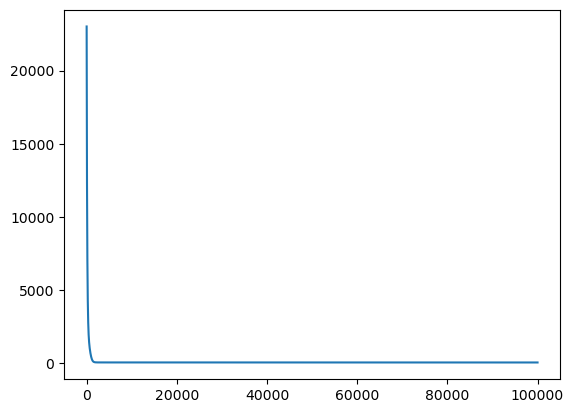

In [5]:

tt = time.time()
fn_history = []
var_history = []
calc = {'upper','lower'}
for i in tqdm(range(100000)):
    var_history.append(matrix.clone())
    fn_history.append(model.energy(matrix, calc).data.cpu().numpy().copy())
    make_gradient_step(model.energy, matrix, calc)
    #scheduler.step()

plt.plot(fn_history)

print(min(fn_history))
print(f'Time used = {(time.time() - tt):.3} s')

In [17]:
shape = model.shape(matrix, prin_dat={'upper'})
fig = px.line(x=shape['intermonolayer'][0], y=shape['intermonolayer'][1])
fig.show()

In [16]:
print('\t test on the sphere energy \n')

N_parts = 100
R = 2
L = 1
B = 1
sigma = 1
moduls = {'B': B, 'sigma': sigma, 'Kt': 0, 'Ka': 0} 

theta_sph = torch.linspace(start=np.pi , end=0, steps=N_parts).to(device)
theta_sph = torch.unsqueeze(theta_sph, dim=0)
dir_sph = np.pi - theta_sph
h_u = torch.linspace(start=1 , end=1, steps=N_parts).to(device)
h_u = torch.unsqueeze(h_u, dim=0)
matrix = torch.cat((theta_sph, dir_sph, h_u, dir_sph, h_u), 0)  
model = ShapeOptimizer(r_start = 0, L = 2*R, z_start = 0, moduls = moduls,\
    augment = False, rho = 1, lam = 1, in_param={'Js_u':0, 'Js_l':0})

shape = model.shape(matrix, prin_dat={'lower','upper'})
en = model.energy(matrix, calc={'lower','upper'}).item()


print('Numerical = ', en)
print('Analytical = ', (4*np.pi*R**2)*(B/2*((2/R)**2) + sigma))

fig = px.line(x=shape['intermonolayer'][0], y=shape['intermonolayer'][1])
# Add Scatter plot
fig.add_scatter(x=shape['lower'][0], y=shape['lower'][1])
# Add Scatter plot
fig.add_scatter(x=shape['upper'][0], y=shape['upper'][1])
# Display the plot
fig.show()

'''
plt.plot(shape['intermonolayer'][0], shape['intermonolayer'][1])
plt.plot(shape['lower'][0], shape['lower'][1])
plt.plot(shape['upper'][0], shape['upper'][1])
'''

	 test on the sphere energy 

Numerical =  150.79234313964844
Analytical =  75.39822368615503


"\nplt.plot(shape['intermonolayer'][0], shape['intermonolayer'][1])\nplt.plot(shape['lower'][0], shape['lower'][1])\nplt.plot(shape['upper'][0], shape['upper'][1])\n"

In [19]:
print('\t test on the cylinder energy \n')

N_parts = 100
R = 1
L = 1
B = 1
sigma = 1
moduls = {'B': B, 'sigma': sigma, 'Kt': 0, 'Ka': 0} 

theta_cyl = torch.linspace(start=np.pi*2/4 , end=np.pi*2/4, steps=N_parts).to(device)
theta_cyl = torch.unsqueeze(theta_cyl, dim=0)
dir_cyl = np.pi - theta_cyl
h_u = torch.linspace(start=1 , end=1, steps=N_parts).to(device)
h_u = torch.unsqueeze(h_u, dim=0)
matrix = torch.cat((theta_cyl, dir_cyl, h_u), 0)  
model = ShapeOptimizer(r_start = 1, L = L, z_start = 0, moduls = moduls,\
    augment = False, rho = 1, lam = 1)

shape = model.shape(matrix, prin_dat={'lower'})
en = model.energy(matrix, calc={'lower'}).item()

print('Numerical = ', en)
print('Analytical = ', 2*np.pi*R*L*(B*(1/R**2)/2 + sigma))

fig = px.line(x=shape['intermonolayer'][0], y=shape['intermonolayer'][1])
# Add Scatter plot
fig.add_scatter(x=shape['lower'][0], y=shape['lower'][1])
# Display the plot
fig.show()

'''
plt.plot(shape['intermonolayer'][0], shape['intermonolayer'][1])
plt.plot(shape['lower'][0], shape['lower'][1])
'''

	 test on the cylinder energy 

Numerical =  9.42478084564209
Analytical =  9.42477796076938


"\nplt.plot(shape['intermonolayer'][0], shape['intermonolayer'][1])\nplt.plot(shape['lower'][0], shape['lower'][1])\n"

test on the 1/4 sphere
Numerical =  27.243253707885742
Analytical =  26.657297628950197


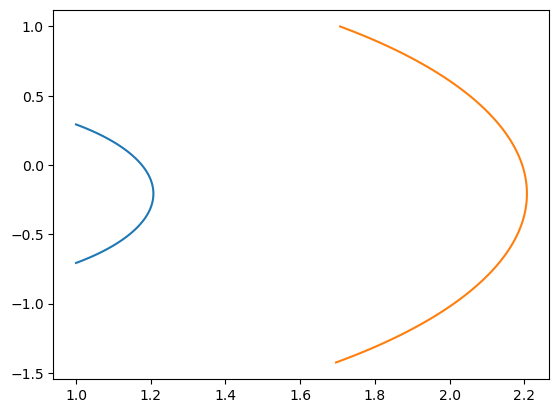

In [9]:
print('test on the 1/4 sphere')

N_parts = 100
R = 1
r0 = R*np.sqrt(2)/2
B = 1
sigma = 1
moduls = {'B': B, 'sigma': sigma, 'Kt': 0, 'Ka': 0} 

theta_cyl = torch.linspace(start=np.pi*3/4 , end=np.pi/4, steps=N_parts).to(device)
theta_cyl = torch.unsqueeze(theta_cyl, dim=0)
dir_cyl = np.pi - theta_cyl
h_u = torch.linspace(start=1 , end=1, steps=N_parts).to(device)
h_u = torch.unsqueeze(h_u, dim=0)
matrix = torch.cat((theta_cyl, dir_cyl, h_u), 0)  
model = ShapeOptimizer(r_start = 1, L = L, z_start = -R*np.sqrt(2)/2, moduls = moduls,
    augment = False, rho = 1, lam = 1)

shape = model.shape(matrix)
en = model.energy(matrix).item()

print('Numerical = ', en)
print('Analytical = ', (4*np.pi*R**2)*(B/2*((2/R)**2) + sigma)*np.sqrt(2)/2)

plt.plot(shape['intermonolayer'][0], shape['intermonolayer'][1])
plt.plot(shape['upper'][0], shape['upper'][1])


In [20]:
D = 100
dia_len = 25
height = 40
point_num = 200
moduls_dis = {'B':0, 'sigma':0.05, 'Kt':10, 'Ka':25}
in_param_dis = {'Js_u':0, 'h0u':1.6}
moduls_pro = {'B':0, 'sigma':0.05, 'Kt':10, 'Ka':25}
in_param_pro = {'Js_l':0, 'h0l':1.6}
rho = 10
lam = 0
po = 2
augment = True
a, b, c = 0.4, 4, 4
add_en = 2
ret_vol = False
vol_type = 2

distal = ShapeOptimizer(r_start=0, L=height/2, D=D, z_start=0, moduls=moduls_dis,
    in_param=in_param_dis, augment=augment, rho=rho, lam=lam, po=po)
proximal = ShapeOptimizer(r_start=dia_len, L=height/2, D=D-dia_len, z_start=0,
    moduls=moduls_pro, in_param=in_param_pro, augment=augment, rho=rho, lam=lam, po=po)
'''
matrix, n, distal, proximal = in_mat_opt(D, dia_len, height, moduls_dis, in_param_dis, 
    moduls_pro, in_param_pro, point_num, rho, lam, po, distal, proximal, augment = True)
'''
circle = False
de = 11
matrix, n = in_mat_rude(D, dia_len, height, point_num = point_num, in_param_dis=in_param_dis,
                  in_param_pro=in_param_pro, circ=circle, de=de)

en = sym_syst(matrix, distal, proximal, D, dia_len, height, n, a, b, c,
             add_en=add_en, ret_vol=ret_vol, vol_type=vol_type)

shape1 = distal.shape(matrix[:,:n], prin_dat={'upper'})
shape2 = proximal.shape(matrix[:,n:], prin_dat={'lower'})

fig = px.line(x=shape1['intermonolayer'][0], y=shape1['intermonolayer'][1])
# Add Scatter plot
fig.add_scatter(x=shape2['intermonolayer'][0], y=shape2['intermonolayer'][1])
# Display the plot
fig.show()

# Store learning results
fn_history = []
var_history = []

print(en)

tensor([853290.9375], grad_fn=<AddBackward0>)


In [21]:
optimizer = torch.optim.Adam([matrix], lr=0.1)
#optimizer = torch.optim.AdamW([matrix], lr=0.0001)
#optimizer = torch.optim.SGD([matrix], lr=0.01, momentum=0.9)
#optimizer = torch.optim.LBFGS([matrix], lr=0.52)
#import torch.optim.lr_scheduler as sh
#scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=1.001)
#scheduler = sh.MultiStepLR(optimizer, milestones=[100, 200], gamma=3)

fn_epoch = []
var_epoch = []

for i in tqdm(range(1000)):
    var_epoch.append(matrix.clone())
    optimizer.zero_grad()
    function_result = sym_syst( matrix, distal, proximal, D, dia_len,
        height, n, a, b, c, add_en,  ret_vol=False, vol_type=vol_type)
    fn_epoch.append(function_result.data.cpu().numpy().copy())
    function_result.backward()
    optimizer.step()
    #scheduler.step()

fn_history.extend(fn_epoch)
var_history.extend(var_epoch)

fn_history_np = np.concatenate(fn_history)
fig = px.line(y=fn_history_np, x=range(len(fn_history_np)), title='Энергия')
fig.show()

#plt.plot(fn_history)
print(min(fn_history_np))

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:25<00:00, 39.20it/s]


95052.89


In [23]:
matras = var_history[201]
 
shape1 = distal.shape(matras[:,:n], prin_dat={'upper'})
shape2 = proximal.shape(matras[:,n:], prin_dat={'lower'})

fig = px.line(x=shape1['intermonolayer'][0], y=shape1['intermonolayer'][1])
# Add Scatter plot
fig.add_scatter(x=shape2['intermonolayer'][0], y=shape2['intermonolayer'][1])
# Display the plot
fig.show()

In [24]:
N_parts = 200
n = 101
D = 100
dia_len =0
height = 30
a, b, c = 1, 2, 3

theta_cyl = torch.linspace(start=np.pi*3/4 , end=np.pi*3/4, steps=N_parts).to(device)
theta_cyl = torch.unsqueeze(theta_cyl, dim=0)
dir_cyl = np.pi - theta_cyl
h_u = torch.linspace(start=1 , end=1, steps=N_parts).to(device)
h_u = torch.unsqueeze(h_u, dim=0)
matrix = torch.cat((theta_cyl, dir_cyl, h_u), 0)  

distal=ShapeOptimizer(r_start=0, L=height/2, D=D, z_start=0)

proximal=ShapeOptimizer(r_start=0, L=height/2, D=D, z_start=10)

en = sym_syst(matrix, distal, proximal, D, dia_len, height, n, a, b, c,
             add_en=True)
shape1 = distal.shape(matrix[:,:n], prin_dat={'upper'})
shape2 = proximal.shape(matrix[:,n:], prin_dat={'lower'})

fig = px.line(x=shape1['intermonolayer'][0], y=shape1['intermonolayer'][1])
# Add Scatter plot
fig.add_scatter(x=shape2['intermonolayer'][0], y=shape2['intermonolayer'][1])
# Display the plot
fig.show()